In [6]:
import sys; sys.path.append('../../../wwa'); from wwa import *

xn,xx,yn,yx = [25,34,-7,6]

mapproj = cartopy.crs.PlateCarree()

# Subset data

In [7]:
# MSWEP subset
da = wrap_lon(xr.open_mfdataset("../../../00_WWA_project_folder/live/data/mswep_nrt/20231*.nc")).precipitation.sel(lon = slice(xn,xx), lat = slice(yn,yx))
da.sel(time = slice("2023-05-01", "2023-05-05")).rename("pr").to_netcdf("mswep_may1-may5.nc")

In [16]:
# CHIRPS subset
da = wrap_lon(xr.open_dataset("../../../00_WWA_project_folder/live/data/chirps_05/chirps-v2.0.2023.days_p05.nc")).precip.sel(longitude = slice(xn,xx), latitude = slice(yn,yx))
da.sel(time = slice("2023-05-01", "2023-05-05")).rename("pr", longitude = "lon", latitude = "lat").to_netcdf("chirps_may1-may5.nc")

In [20]:
da = wrap_lon(xr.open_dataset("../../../00_WWA_project_folder/live/data/cpc/precip.2023.nc")).precip.sel(lon = slice(xn,xx), lat = slice(yn,yx))
da.sel(time = slice("2023-05-01", "2023-05-05")).rename("pr").to_netcdf("cpc_may1-may5.nc")

# Event maps

In [29]:
era5 = wrap_lon(convert_units_to(xr.open_dataset("adaptor.mars.internal-1716299681.020658-10884-2-f25714ef-d906-4470-a89e-784e69760a83.nc").tp, "mm")).rename(longitude = "lon", latitude = "lat")
era5 = era5.sel(time = slice("2023-05-01", "2023-05-05"), lon = slice(xn,xx), lat = slice(yn,yx)).sum("time")

mswep = xr.open_dataset("mswep_may1-may5.nc").pr.sel(time = slice("2023-05-01", "2023-05-05"), lon = slice(xn,xx), lat = slice(yn,yx)).sum("time")

chirps = xr.open_dataset("chirps_may1-may5.nc").pr.sel(time = slice("2023-05-01", "2023-05-05"), lon = slice(xn,xx), lat = slice(yn,yx)).sum("time")

cpc = xr.open_dataset("cpc_may1-may5.nc").pr.sel(time = slice("2023-05-01", "2023-05-05"), lon = slice(xn,xx), lat = slice(yn,yx)).sum("time")

tamsat = wrap_lon(xr.open_dataset("01-tamsatDaily.v3.1-20230401-20230515-20240521_25.0_34.0_-7.0_6.0.nc")).rfe.sel(time = slice("2023-05-01", "2023-05-05"), lon = slice(xn,xx), lat = slice(yn,yx)).sum("time")

obs = {ds : eval(ds) for ds in ["chirps", "cpc", "era5", "mswep", "tamsat"]}
letters = ["a","b","c","d","e"]

In [34]:
sf = gpd.read_file("sf").to_crs(mapproj)

xn,xx,yn,yx = [26,33,-6,2]

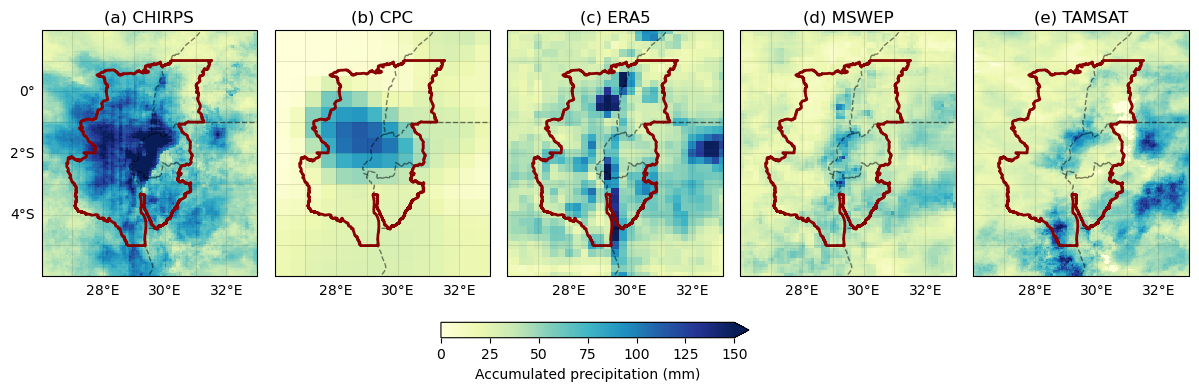

In [55]:
plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 150}

nc = 5; nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (3 * nc, 4 * nr), dpi = 100, sharex = True, sharey = True,
                        subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})

plt.subplots_adjust(wspace = 0.01)

for i in range(5):
    ds = list(obs.keys())[i]
    ax = fig.axes[i]
    
    da = obs[ds]
    cbar = da.plot(ax = ax, **plot_kwargs, add_colorbar = False)
    ax.set_title("("+letters[i]+") "+ds.upper())

    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
    
    ax.gridlines(color='black', alpha=0.1, xlocs = range(26,40), ylocs = range(-6,4))
    ax.gridlines(color='black', alpha=0, xlocs = range(26,40,2), draw_labels = ["bottom"])

axs[0].gridlines(color='black', alpha=0, ylocs = range(-6,4,2), draw_labels = ["left"])
plt.colorbar(cbar, ax = axs, location = "bottom", extend = "max", label = "Accumulated precipitation (mm)", fraction = 0.05)

plt.savefig("wcrp-obs-figure.png")